#**Telecom X – Parte 2: Predicción de Cancelación**

**🎯 Misión**

Tu nueva misión es desarrollar modelos predictivos capaces de prever qué clientes tienen mayor probabilidad de cancelar sus servicios.

La empresa quiere anticiparse al problema de la cancelación, y te corresponde a ti construir un pipeline robusto para esta etapa inicial de modelado.

**🧠 Objetivos del Desafío**


*   Preparar los datos para el modelado (tratamiento, codificación, normalización).
*   Realizar análisis de correlación y selección de variables.
*   Entrenar dos o más modelos de clasificación.
*   Evaluar el rendimiento de los modelos con métricas.
*   Interpretar los resultados, incluyendo la importancia de las variables.
*   Crear una conclusión estratégica señalando los principales factores que influyen en la cancelación.

## Paqueterías:

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

## 🛠️ Preparación de los Datos

### Extracción del Archivo Tratado

In [6]:
datos='https://raw.githubusercontent.com/LeoSR02/Challenge3-data-science_TelecomX_parte2/refs/heads/main/datos_tratados.csv'

In [7]:
datos=pd.read_csv(datos)

In [8]:
datos.head()

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total,Cuentas_Diarias
0,0002-ORFBO,0,Female,0,1,1,9,1,0,DSL,...,0,1,1,0,One year,1,Mailed check,65.6,593.30,2.16
1,0003-MKNFE,0,Male,0,0,0,9,1,1,DSL,...,0,0,0,1,Month-to-month,0,Mailed check,59.9,542.40,1.97
2,0004-TLHLJ,1,Male,0,0,0,4,1,0,Fiber optic,...,1,0,0,0,Month-to-month,1,Electronic check,73.9,280.85,2.43
3,0011-IGKFF,1,Male,1,1,0,13,1,0,Fiber optic,...,1,0,1,1,Month-to-month,1,Electronic check,98.0,1237.85,3.22
4,0013-EXCHZ,1,Female,1,1,0,3,1,0,Fiber optic,...,0,1,1,0,Month-to-month,1,Mailed check,83.9,267.40,2.76


In [9]:
datos.gender.unique()

array(['Female', 'Male'], dtype=object)

In [10]:
datos['gender'] = datos['gender'].map({'Male': 1, 'Female': 0})

In [11]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7267 non-null   object 
 1   Churn             7267 non-null   int64  
 2   gender            7267 non-null   int64  
 3   SeniorCitizen     7267 non-null   int64  
 4   Partner           7267 non-null   int64  
 5   Dependents        7267 non-null   int64  
 6   tenure            7267 non-null   int64  
 7   PhoneService      7267 non-null   int64  
 8   MultipleLines     7267 non-null   int64  
 9   InternetService   7267 non-null   object 
 10  OnlineSecurity    7267 non-null   int64  
 11  OnlineBackup      7267 non-null   int64  
 12  DeviceProtection  7267 non-null   int64  
 13  TechSupport       7267 non-null   int64  
 14  StreamingTV       7267 non-null   int64  
 15  StreamingMovies   7267 non-null   int64  
 16  Contract          7267 non-null   object 


### Eliminación de Columnas Irrelevantes

In [12]:
#Columna que no representa ningun valor para el modelado
datos=datos.drop(columns='customerID')
datos.columns

Index(['Churn', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'Charges.Monthly', 'Charges.Total', 'Cuentas_Diarias'],
      dtype='object')

In [13]:
xIn=datos.drop(columns='Churn')
yOut=datos['Churn']

### Verificación de la Proporción de Cancelación (Churn)

In [14]:
umbral = 0.70
columnas_a_eliminar = []

for columna in datos.columns:
    if datos[columna].nunique() <= 2 or datos[columna].dtype == 'object':
        frecuencia_max = datos[columna].value_counts(normalize=True).max()
        if frecuencia_max > umbral:
            columnas_a_eliminar.append(columna)
            print(f"Columna '{columna}' tiene {frecuencia_max*100:.2f}% en una categoría.")
if columnas_a_eliminar:
    print(f"\nColumnas a eliminar por desbalance (>{umbral*100}% en una categoría):")
    print(columnas_a_eliminar)
else:
    print(f"No se encontraron columnas con desbalance >{umbral*100}%.")

Columna 'Churn' tiene 74.28% en una categoría.
Columna 'SeniorCitizen' tiene 83.73% en una categoría.
Columna 'PhoneService' tiene 90.27% en una categoría.
Columna 'OnlineSecurity' tiene 71.40% en una categoría.
Columna 'TechSupport' tiene 71.05% en una categoría.

Columnas a eliminar por desbalance (>70.0% en una categoría):
['Churn', 'SeniorCitizen', 'PhoneService', 'OnlineSecurity', 'TechSupport']


In [15]:
#Datos irrelevantes para el modelo <90%
datos=datos.drop(columns='PhoneService')
datos.columns

Index(['Churn', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'Charges.Monthly',
       'Charges.Total', 'Cuentas_Diarias'],
      dtype='object')

### Encoding

In [16]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Churn             7267 non-null   int64  
 1   gender            7267 non-null   int64  
 2   SeniorCitizen     7267 non-null   int64  
 3   Partner           7267 non-null   int64  
 4   Dependents        7267 non-null   int64  
 5   tenure            7267 non-null   int64  
 6   MultipleLines     7267 non-null   int64  
 7   InternetService   7267 non-null   object 
 8   OnlineSecurity    7267 non-null   int64  
 9   OnlineBackup      7267 non-null   int64  
 10  DeviceProtection  7267 non-null   int64  
 11  TechSupport       7267 non-null   int64  
 12  StreamingTV       7267 non-null   int64  
 13  StreamingMovies   7267 non-null   int64  
 14  Contract          7267 non-null   object 
 15  PaperlessBilling  7267 non-null   int64  
 16  PaymentMethod     7267 non-null   object 


In [17]:
categoricas = datos.select_dtypes(include=['object']).columns.tolist()
print("Variables categóricas:", categoricas)

Variables categóricas: ['InternetService', 'Contract', 'PaymentMethod']


In [18]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

columnas=xIn.columns
one_hot_encoder = make_column_transformer(
    (OneHotEncoder(drop='if_binary'),categoricas),
    remainder='passthrough',
    sparse_threshold=0
)
x=one_hot_encoder.fit_transform(xIn)
one_hot_encoder.get_feature_names_out(columnas)
xIn=pd.DataFrame(x, columns=one_hot_encoder.get_feature_names_out(columnas))

In [19]:
xIn.columns

Index(['onehotencoder__InternetService_DSL',
       'onehotencoder__InternetService_Fiber optic',
       'onehotencoder__InternetService_No',
       'onehotencoder__Contract_Month-to-month',
       'onehotencoder__Contract_One year', 'onehotencoder__Contract_Two year',
       'onehotencoder__PaymentMethod_Bank transfer (automatic)',
       'onehotencoder__PaymentMethod_Credit card (automatic)',
       'onehotencoder__PaymentMethod_Electronic check',
       'onehotencoder__PaymentMethod_Mailed check', 'remainder__gender',
       'remainder__SeniorCitizen', 'remainder__Partner',
       'remainder__Dependents', 'remainder__tenure', 'remainder__PhoneService',
       'remainder__MultipleLines', 'remainder__OnlineSecurity',
       'remainder__OnlineBackup', 'remainder__DeviceProtection',
       'remainder__TechSupport', 'remainder__StreamingTV',
       'remainder__StreamingMovies', 'remainder__PaperlessBilling',
       'remainder__Charges.Monthly', 'remainder__Charges.Total',
       'remaind

In [20]:
xIn

,onehotencoder__InternetService_DSL,onehotencoder__InternetService_Fiber optic,onehotencoder__InternetService_No,onehotencoder__Contract_Month-to-month,onehotencoder__Contract_One year,onehotencoder__Contract_Two year,onehotencoder__PaymentMethod_Bank transfer (automatic),onehotencoder__PaymentMethod_Credit card (automatic),onehotencoder__PaymentMethod_Electronic check,onehotencoder__PaymentMethod_Mailed check,...,remainder__OnlineSecurity,remainder__OnlineBackup,remainder__DeviceProtection,remainder__TechSupport,remainder__StreamingTV,remainder__StreamingMovies,remainder__PaperlessBilling,remainder__Charges.Monthly,remainder__Charges.Total,remainder__Cuentas_Diarias
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,65.60,593.30,2.16
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,59.90,542.40,1.97
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,73.90,280.85,2.43
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,98.00,1237.85,3.22
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,83.90,267.40,2.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7262,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,55.15,742.90,1.81
7263,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,85.10,1873.70,2.80
7264,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,50.30,92.75,1.65
7265,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,67.85,4627.65,2.23


In [21]:
yOut

,Churn
0,0
1,0
2,1
3,1
4,1
...,...
7262,0
7263,1
7264,0
7265,0


### Balanceo de Clases

In [22]:
datos.Churn.value_counts()

,count
Churn,
0,5398
1,1869


In [23]:
xIn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 27 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   onehotencoder__InternetService_DSL                      7267 non-null   float64
 1   onehotencoder__InternetService_Fiber optic              7267 non-null   float64
 2   onehotencoder__InternetService_No                       7267 non-null   float64
 3   onehotencoder__Contract_Month-to-month                  7267 non-null   float64
 4   onehotencoder__Contract_One year                        7267 non-null   float64
 5   onehotencoder__Contract_Two year                        7267 non-null   float64
 6   onehotencoder__PaymentMethod_Bank transfer (automatic)  7267 non-null   float64
 7   onehotencoder__PaymentMethod_Credit card (automatic)    7267 non-null   float64
 8   onehotencoder__PaymentMethod_Electroni

In [24]:
over_sampling=SMOTE()
x_over,y_over=over_sampling.fit_resample(xIn,yOut)

Para evitar tener demasiados datos idénticos, se puede utilizar la técnica SMOTE, que consiste en sintetizar nueva información a partir de la información existente. Estos datos "sintéticos" están relativamente cerca de los datos reales, pero no son idénticos.

In [25]:
y_over.value_counts(normalize=False)

,count
Churn,
0,5398
1,5398


## **🎯 Correlación y Selección de Variables**

### Análisis de Correlación

In [26]:
datosOneHotEncoder=pd.concat([x_over.reset_index(drop=True), y_over.reset_index(drop=True)], axis=1)
datosOneHotEncoder

,onehotencoder__InternetService_DSL,onehotencoder__InternetService_Fiber optic,onehotencoder__InternetService_No,onehotencoder__Contract_Month-to-month,onehotencoder__Contract_One year,onehotencoder__Contract_Two year,onehotencoder__PaymentMethod_Bank transfer (automatic),onehotencoder__PaymentMethod_Credit card (automatic),onehotencoder__PaymentMethod_Electronic check,onehotencoder__PaymentMethod_Mailed check,...,remainder__OnlineBackup,remainder__DeviceProtection,remainder__TechSupport,remainder__StreamingTV,remainder__StreamingMovies,remainder__PaperlessBilling,remainder__Charges.Monthly,remainder__Charges.Total,remainder__Cuentas_Diarias,Churn
0,1.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,...,1.0,0.000000,1.0,1.0,0.0,1.0,65.600000,593.300000,2.160000,0
1,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,...,0.0,0.000000,0.0,0.0,1.0,0.0,59.900000,542.400000,1.970000,0
2,0.0,1.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,...,0.0,1.000000,0.0,0.0,0.0,1.0,73.900000,280.850000,2.430000,1
3,0.0,1.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,...,1.0,1.000000,0.0,1.0,1.0,1.0,98.000000,1237.850000,3.220000,1
4,0.0,1.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,...,0.0,0.000000,1.0,1.0,0.0,1.0,83.900000,267.400000,2.760000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10791,0.0,1.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,...,0.0,0.261461,0.0,0.0,0.0,1.0,74.932343,74.932343,2.464771,1
10792,0.0,1.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,...,0.0,0.000000,0.0,0.0,1.0,1.0,84.759164,170.067395,2.788309,1
10793,0.0,1.0,0.0,1.0,0.000000,0.000000,0.000000,0.522108,0.477892,0.0,...,0.0,0.000000,0.0,1.0,1.0,1.0,95.629679,2094.227528,3.143452,1
10794,0.0,1.0,0.0,1.0,0.000000,0.000000,0.009433,0.000000,0.990567,0.0,...,1.0,1.000000,0.0,1.0,1.0,1.0,106.409433,5127.887269,3.500283,1


In [27]:
datosOHE=datosOneHotEncoder.corr()
datosOHE['Churn']

,Churn
onehotencoder__InternetService_DSL,-0.157747
onehotencoder__InternetService_Fiber optic,0.361599
onehotencoder__InternetService_No,-0.290577
onehotencoder__Contract_Month-to-month,0.489035
onehotencoder__Contract_One year,-0.223756
onehotencoder__Contract_Two year,-0.391857
onehotencoder__PaymentMethod_Bank transfer (automatic),-0.143660
onehotencoder__PaymentMethod_Credit card (automatic),-0.166534
onehotencoder__PaymentMethod_Electronic check,0.344616
onehotencoder__PaymentMethod_Mailed check,-0.115696


In [28]:
variables_correlacionadas = [
    "onehotencoder__Contract_Month-to-month",       # Positiva (0.48)
    "remainder__tenure",                           # Negativa (-0.40)
    "onehotencoder__Contract_Two year",            # Negativa (-0.39)
    "onehotencoder__InternetService_Fiber optic",  # Positiva (0.36)
    "onehotencoder__PaymentMethod_Electronic check", # Positiva (0.34)
    "onehotencoder__InternetService_No",           # Negativa (-0.29)
    "onehotencoder__Contract_One year",            # Negativa (-0.22)
    "remainder__Charges.Monthly",                  # Positiva (0.24)
    "remainder__Cuentas_Diarias",                  # Positiva (0.24)
    "remainder__Dependents",                       # Negativa (-0.21)
    "remainder__TechSupport",                      # Negativa (-0.21)
    "remainder__OnlineSecurity",                   # Negativa (-0.21)
    "remainder__PaperlessBilling",                 # Positiva (0.23)
    "remainder__Partner",                          # Negativa (-0.18)
    "remainder__SeniorCitizen"                     # Positiva (0.17)
]

### Análisis Dirigido

In [29]:
def ancho_bin(df,columna):
  q75,q25 = np.percentile(df[columna],[75,25])
  iqr = q75-q25
  ancho = 2 * iqr * np.power(len(df[columna]), -1/3)
  return int(ancho)

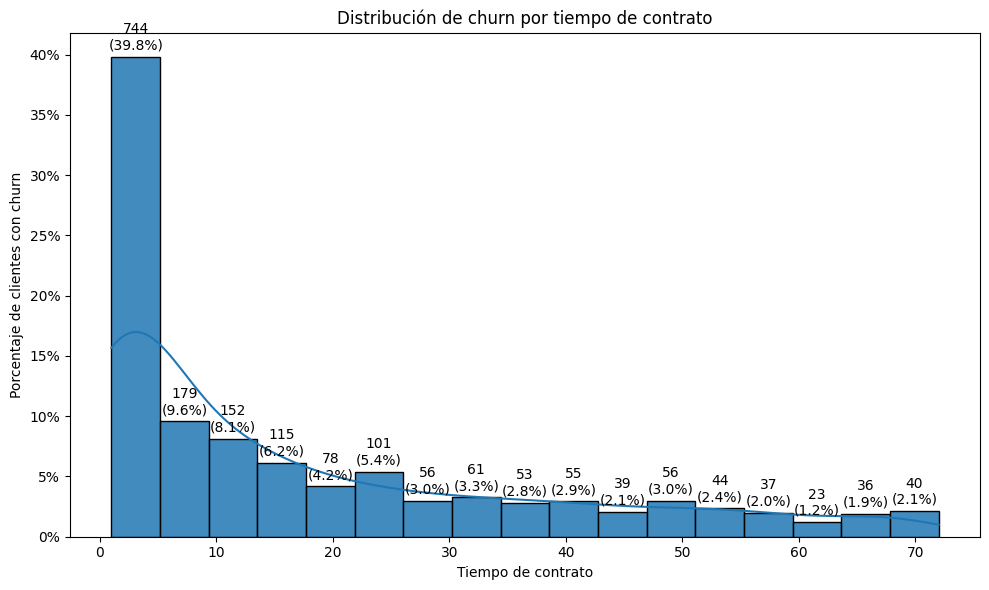

In [30]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# Serie limpia (solo churn=1)
s = (datos.loc[datos['Churn'].eq(1), 'tenure']
         .dropna()
         .astype(float))

# Bins (usa los que prefieras; aquí FD)
bins = np.histogram_bin_edges(s, bins='fd')

# Conteos y % por bin
counts, edges = np.histogram(s, bins=bins)
pcts = counts / counts.sum() * 100

# Histograma en %
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(s, bins=edges, stat='percent', kde=True,
             edgecolor='black', alpha=0.85, ax=ax)

# Etiquetas: conteo y %
labels = [f"{c:,.0f}\n({p:.1f}%)" for c, p in zip(counts, pcts)]
ax.bar_label(ax.containers[0], labels=labels, padding=3)

ax.set(title="Distribución de churn por tiempo de contrato",
       xlabel="Tiempo de contrato",
       ylabel="Porcentaje de clientes con churn")
ax.yaxis.set_major_formatter(PercentFormatter(100, decimals=0))
plt.tight_layout()
plt.show()


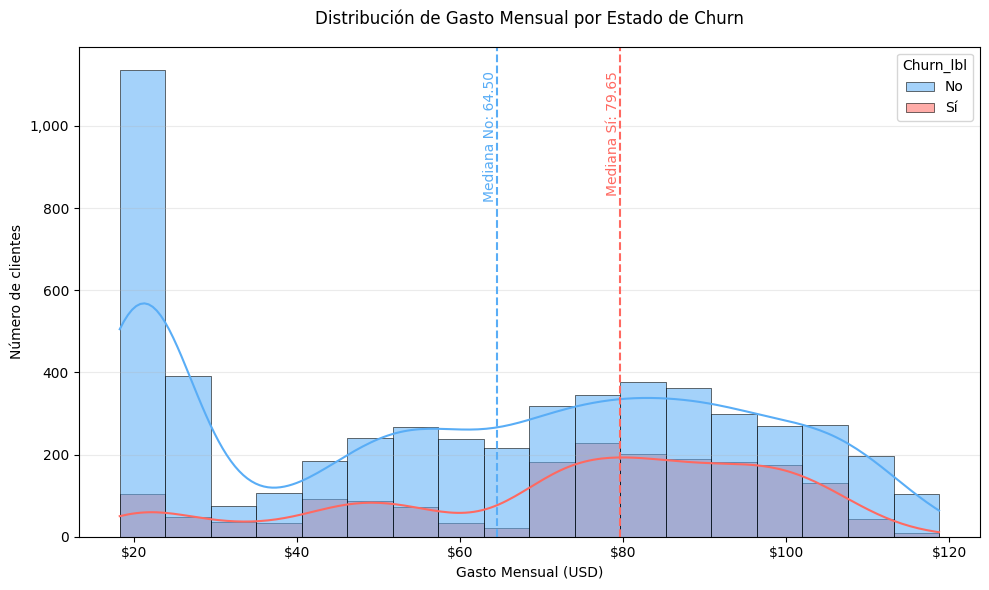

In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

# --- 1) Preparación de datos ---
df = datos[['Charges.Monthly', 'Churn']].copy()
df['Charges.Monthly'] = pd.to_numeric(df['Charges.Monthly'], errors='coerce')
df = df.dropna(subset=['Charges.Monthly', 'Churn'])

# Etiquetas para la leyenda
df['Churn_lbl'] = df['Churn'].map({0: 'No', 1: 'Sí'})

# Bins comunes (evita “engaños” entre grupos)
bins = np.histogram_bin_edges(df['Charges.Monthly'], bins='fd')  # o 'auto'

# --- 2) Gráfico ---
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(
    data=df,
    x='Charges.Monthly',
    hue='Churn_lbl',
    hue_order=['No', 'Sí'],
    bins=bins,
    kde=True,
    multiple='layer',          # 'stack' para apilar, 'fill' para % por bin
    common_bins=True,
    common_norm=False,         # NO normalizar entre grupos
    element='bars',            # 'step' si prefieres contornos
    alpha=0.55,
    edgecolor='black',
    linewidth=0.4,
    palette={'No': '#59adf6', 'Sí': '#ff6961'}
)

# Medianas por grupo
medianas = df.groupby('Churn_lbl')['Charges.Monthly'].median()
for lbl, color in [('No', '#59adf6'), ('Sí', '#ff6961')]:
    m = medianas.get(lbl, None)
    if pd.notna(m):
        ax.axvline(m, color=color, linestyle='--', linewidth=1.5)
        ax.text(m, ax.get_ylim()[1]*0.95, f'Mediana {lbl}: {m:,.2f}',
                color=color, rotation=90, va='top', ha='right')

# --- 3) Estética y formato ---
ax.set_title("Distribución de Gasto Mensual por Estado de Churn", pad=16)
ax.set_xlabel("Gasto Mensual (USD)")
ax.set_ylabel("Número de clientes")
ax.grid(axis='y', alpha=0.25)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))   # miles en Y
ax.xaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))  # USD en X
plt.tight_layout()
plt.show()


NameError: name 'g' is not defined

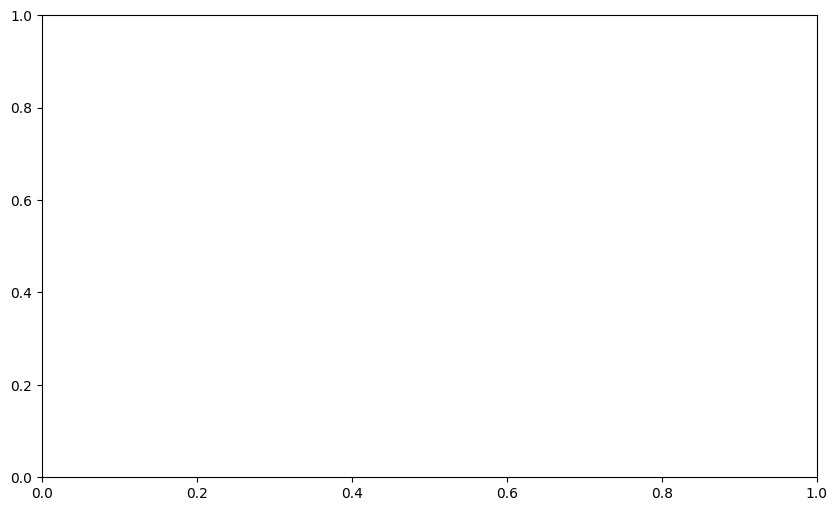

In [38]:
from matplotlib.ticker import PercentFormatter

# g: dfFrame con columnas ['Contract','n','rate']

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    df=g, x='Contract', y='rate',
    palette='colorblind', edgecolor='black', linewidth=0.5,
    errorbar=None   #
)

# etiquetas: % y n
for i, r in g.reset_index().iterrows():
    ax.text(
        i, r['rate'] + 0.01,
        f"{r['rate']*100:.1f}%\n(n={int(r['n']):,})",
        ha='center', va='bottom', fontsize=10
    )

ax.set_ylim(0, g['rate'].max() + 0.1)
ax.set_title("Tasa de cancelación por tipo de contrato", pad=16)
ax.set_xlabel("Tipo de contrato")
ax.set_ylabel("Tasa de churn")
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.grid(axis='y', alpha=0.25)
plt.tight_layout()
plt.show()


/tmp/ipython-input-2397846211.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  med = df.groupby('Churn_lbl')['Charges.Total'].median()


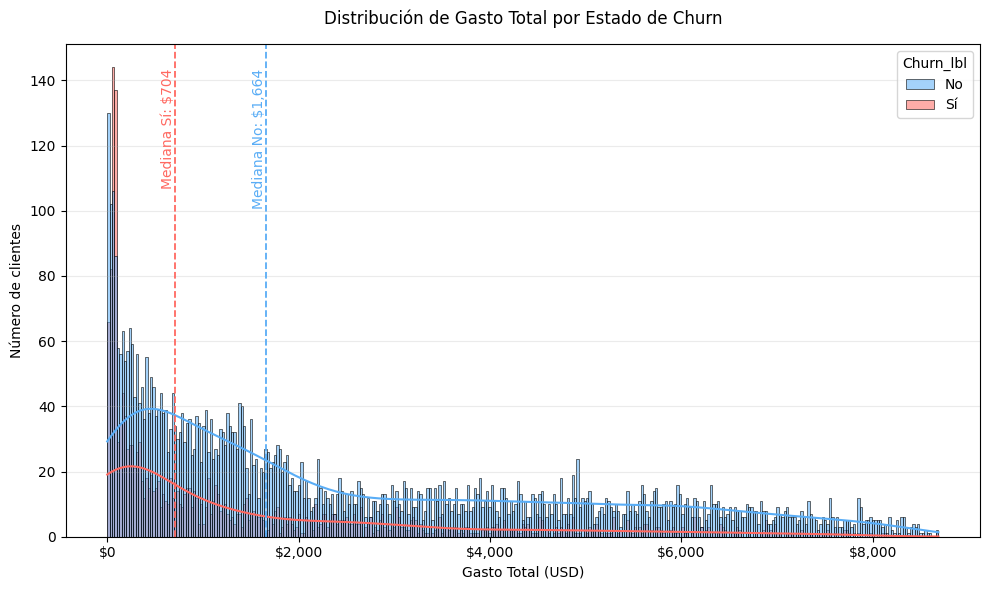

In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

# --- Datos limpios ---
df = datos[['Charges.Total', 'Churn']].copy()
df['Charges.Total'] = pd.to_numeric(df['Charges.Total'], errors='coerce')
df = df.dropna(subset=['Charges.Total', 'Churn'])

# Etiquetas y colores
df['Churn_lbl'] = df['Churn'].map({0: 'No', 1: 'Sí'}).astype('category')
palette = {'No': '#59adf6', 'Sí': '#ff6961'}

# --- Bins (usa tu función o FD si prefieres) ---
bins = ancho_bin(df, 'Charges.Total')          # si tu función devuelve int/edges
# bins = np.histogram_bin_edges(df['Charges.Total'], bins='fd')  # alternativa

# --- Gráfico ---
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(
    data=df,
    x='Charges.Total',
    hue='Churn_lbl',
    bins=bins,
    kde=True,
    multiple='layer',        # superpuesto (usa 'fill' para proporciones por bin)
    common_bins=True,
    common_norm=False,       # no normalizar entre grupos
    edgecolor='black',
    linewidth=0.4,
    alpha=0.55,
    palette=palette,
    ax=ax
)

# Medianas por grupo
med = df.groupby('Churn_lbl')['Charges.Total'].median()
for lbl, color in palette.items():
    m = med.get(lbl)
    if pd.notna(m):
        ax.axvline(m, color=color, linestyle='--', linewidth=1.3)
        ax.text(m, ax.get_ylim()[1]*0.95, f'Mediana {lbl}: ${m:,.0f}',
                color=color, rotation=90, va='top', ha='right')

# Estética y formato
ax.set_title("Distribución de Gasto Total por Estado de Churn", pad=14)
ax.set_xlabel("Gasto Total (USD)")
ax.set_ylabel("Número de clientes")
ax.grid(axis='y', alpha=0.25)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.xaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
plt.tight_layout()
plt.show()


## Modelado Predictivo

### Separación de Datos

In [41]:
x_over.shape

(10796, 27)

In [42]:
label_encoder = LabelEncoder()
y=label_encoder.fit_transform(y_over)
y

array([0, 0, 1, ..., 1, 1, 1])

### Creación de Modelos

#### Random Forest Classifier

In [69]:
x_trainRFC, x_testRFC, y_trainRFC, y_testRFC = train_test_split(x_over, y, test_size=0.2, random_state=42,stratify=y_over)

In [70]:
modeloRFC = RandomForestClassifier(random_state=42,max_depth=10)
modeloRFC.fit(x_trainRFC, y_trainRFC)
y_pred = modeloRFC.predict(x_testRFC)
modeloRFC.score(x_testRFC, y_testRFC)

0.8611111111111112

#### Dummy

In [56]:
x_trainDummy, x_testDummy, y_trainDummy, y_testDummy = train_test_split(x_over, y, test_size=0.2, random_state=42,stratify=y_over)

In [57]:
baseline=DummyClassifier()
baseline.fit(x_trainDummy, y_trainDummy)


baseline.score(x_testDummy, y_testDummy)

0.5

#### DecisionTreeClassifier

In [71]:
x_trainDTC, x_testDTC, y_trainDTC, y_testDTC = train_test_split(x_over, y, test_size=0.2, random_state=42,stratify=y_over)

In [72]:
arbol=DecisionTreeClassifier(random_state=42, max_depth=5)
arbol.fit(x_trainDTC, y_trainDTC)

arbol.score(x_testDTC, y_testDTC)

0.8023148148148148

In [73]:
arbol.score(x_trainDTC, y_trainDTC)

0.8124131542380731

### Evaluación de los Modelos


— TRAIN —  Acc: 0.5000  | BalAcc: 0.5000
              precision    recall  f1-score   support

          No      0.500     1.000     0.667      4318
          Sí      0.000     0.000     0.000      4318

    accuracy                          0.500      8636
   macro avg      0.250     0.500     0.333      8636
weighted avg      0.250     0.500     0.333      8636



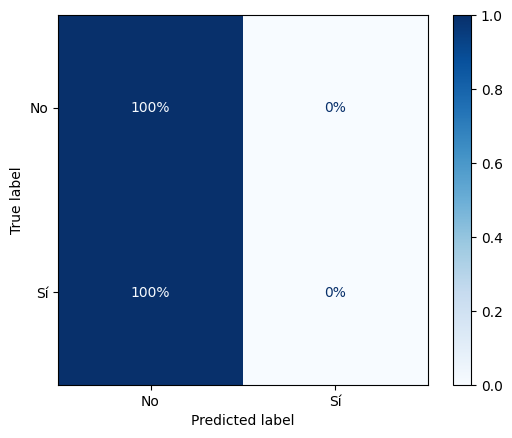


— TEST —  Acc: 0.5000  | BalAcc: 0.5000
              precision    recall  f1-score   support

          No      0.500     1.000     0.667      1080
          Sí      0.000     0.000     0.000      1080

    accuracy                          0.500      2160
   macro avg      0.250     0.500     0.333      2160
weighted avg      0.250     0.500     0.333      2160



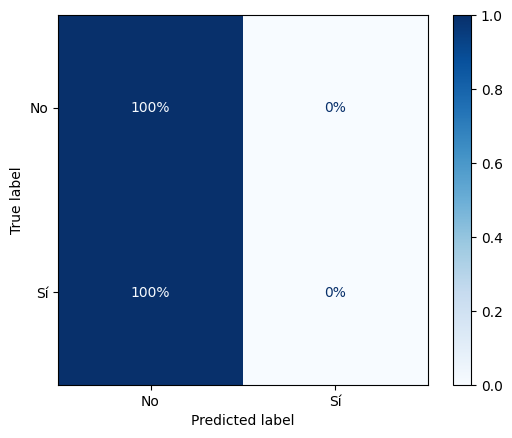

In [68]:
#Dummy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, classification_report,
    ConfusionMatrixDisplay
)

def eval_split(name, model, X, y):
    yhat = model.predict(X)
    print(f"\n— {name} —  Acc: {accuracy_score(y, yhat):.4f}  | BalAcc: {balanced_accuracy_score(y, yhat):.4f}")
    print(classification_report(y, yhat, labels=[0,1], target_names=['No','Sí'],
                                digits=3, zero_division=0))
    ConfusionMatrixDisplay.from_predictions(
        y, yhat, labels=[0,1], display_labels=['No','Sí'],
        normalize='true', values_format=".0%", cmap='Blues'
    )
    plt.show()

eval_split("TRAIN", baseline, x_trainDummy, y_trainDummy)
eval_split("TEST",  baseline, x_testDummy,  y_testDummy)


Mejores params: {'ccp_alpha': 0.001, 'max_depth': 10, 'min_samples_leaf': 10}

— TRAIN — Acc:0.8428 | BalAcc:0.8428
              precision    recall  f1-score   support

          No       0.84      0.85      0.84      4318
          Sí       0.85      0.84      0.84      4318

    accuracy                           0.84      8636
   macro avg       0.84      0.84      0.84      8636
weighted avg       0.84      0.84      0.84      8636



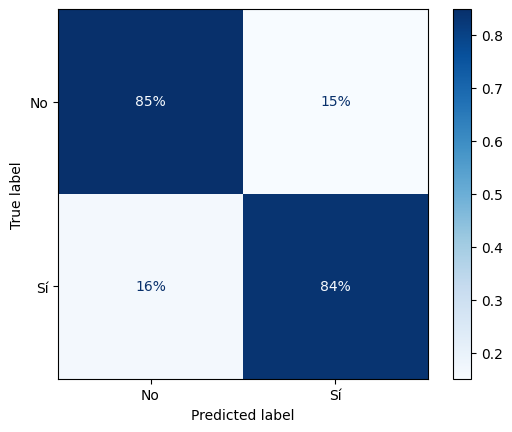


— TEST — Acc:0.8287 | BalAcc:0.8287
              precision    recall  f1-score   support

          No       0.83      0.82      0.83      1080
          Sí       0.82      0.84      0.83      1080

    accuracy                           0.83      2160
   macro avg       0.83      0.83      0.83      2160
weighted avg       0.83      0.83      0.83      2160



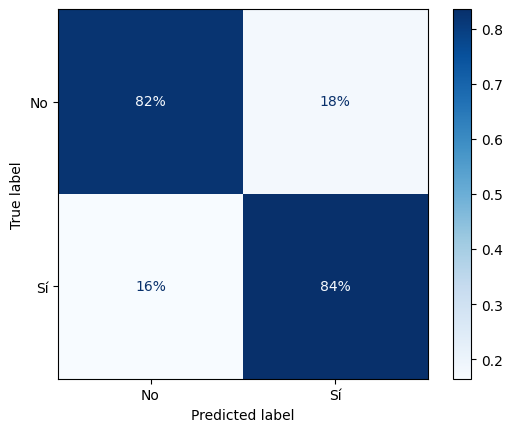

In [74]:
#DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'max_depth': [4,6,8,10,None],
    'min_samples_leaf': [1,5,10],
    'ccp_alpha': [0.0, 0.001, 0.005, 0.01]   # poda
}
grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid, scoring='f1_weighted', cv=5, n_jobs=-1
).fit(x_trainDTC, y_trainDTC)

arbol_mejor = grid.best_estimator_
print("Mejores params:", grid.best_params_)
quick_eval(arbol_mejor, x_trainDTC, y_trainDTC, x_testDTC, y_testDTC)



— TRAIN — Acc:0.8967 | BalAcc:0.8967 | P:0.8969 | R:0.8967 | F1:0.8967

— TEST — Acc:0.8611 | BalAcc:0.8611 | P:0.8617 | R:0.8611 | F1:0.8611
AUC-ROC (TEST): 0.9430


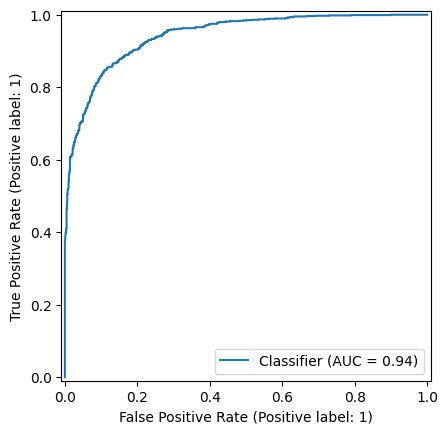

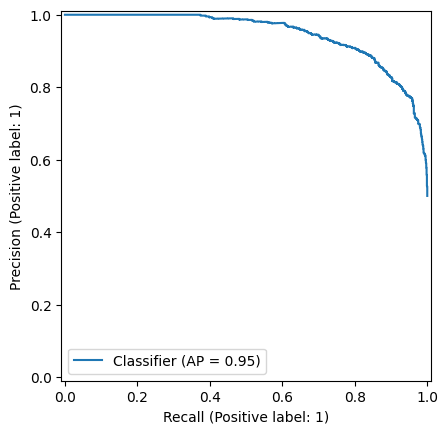

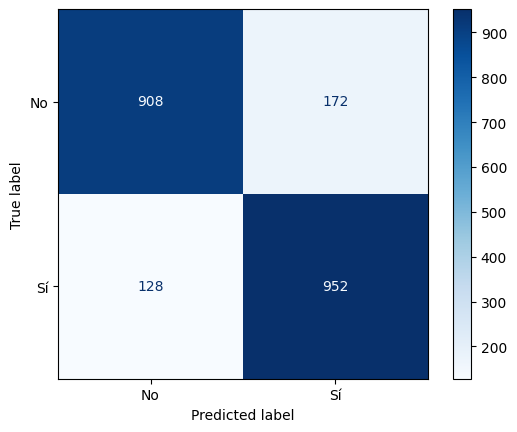

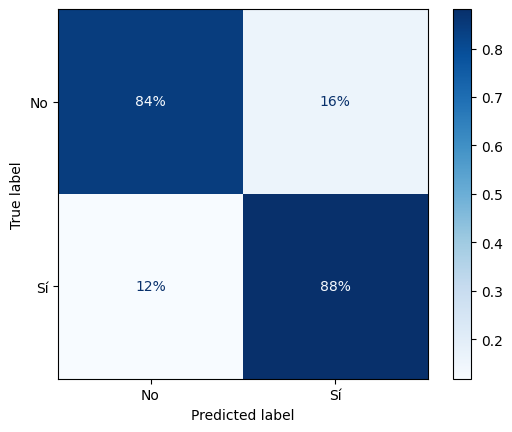


Top 10 features por importancia:
 onehotencoder__Contract_Month-to-month           0.168
onehotencoder__PaymentMethod_Electronic check    0.117
remainder__tenure                                0.081
remainder__PaperlessBilling                      0.060
onehotencoder__Contract_Two year                 0.059
remainder__Charges.Total                         0.058
onehotencoder__InternetService_Fiber optic       0.055
remainder__OnlineSecurity                        0.045
remainder__TechSupport                           0.045
remainder__Charges.Monthly                       0.042
dtype: float64


In [64]:
#Random Forest Classifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_recall_fscore_support,
    roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
)

def eval_rf(model, Xtr, ytr, Xte, yte, feature_names=None):
    # Predicciones
    yhat_tr = model.predict(Xtr)
    yhat_te = model.predict(Xte)
    yprob_te = model.predict_proba(Xte)[:, 1]  # RF lo tiene

    # Métricas rápidas
    def block(y, yhat, name):
        acc  = accuracy_score(y, yhat)
        bacc = balanced_accuracy_score(y, yhat)
        p,r,f1,_ = precision_recall_fscore_support(y, yhat, average='weighted', zero_division=0)
        print(f"\n— {name} — Acc:{acc:.4f} | BalAcc:{bacc:.4f} | P:{p:.4f} | R:{r:.4f} | F1:{f1:.4f}")

    block(ytr, yhat_tr, "TRAIN")
    block(yte, yhat_te, "TEST")

    # AUC + curvas
    print(f"AUC-ROC (TEST): {roc_auc_score(yte, yprob_te):.4f}")
    RocCurveDisplay.from_predictions(yte, yprob_te); plt.show()
    PrecisionRecallDisplay.from_predictions(yte, yprob_te); plt.show()

    # Matrices de confusión (conteos y %)
    ConfusionMatrixDisplay.from_predictions(yte, yhat_te, labels=[0,1], display_labels=['No','Sí'], cmap='Blues'); plt.show()
    ConfusionMatrixDisplay.from_predictions(yte, yhat_te, labels=[0,1], display_labels=['No','Sí'],
                                            normalize='true', values_format=".0%", cmap='Blues'); plt.show()

    # Top features
    if hasattr(model, "feature_importances_"):
        names = feature_names if feature_names is not None else getattr(Xte, "columns", np.arange(Xte.shape[1]))
        fi = pd.Series(model.feature_importances_, index=names).sort_values(ascending=False).head(10)
        print("\nTop 10 features por importancia:\n", fi.round(3))

# úsalo así:
eval_rf(modeloRFC, x_trainRFC, y_trainRFC, x_testRFC, y_testRFC, feature_names=getattr(x_testRFC, 'columns', None))


**¿Cuál modelo tuvo el mejor desempeño?**

El Random Forest Classifier fue el modelo con mejor desempeño, con una accuracy en TEST de 0.9399, superior a la del Decision Tree (0.8319) y significativamente mejor que el modelo Dummy (0.50).
También muestra mejores métricas en precisión, recall y f1-score para ambas clases.

---
**¿Algún modelo presentó overfitting o underfitting? Si es así, considera las posibles causas y ajustes:**

Hubo ligero overfitting en el Random Forest; el árbol podado está bien regulado (sin señales claras de over/underfitting) y el Dummy es, por definición, underfitting.

**Dummy (underfitting)**

TRAIN/TEST 0.50
Solo sirve como línea base y no captura ninguna relación real en los datos.

**Decision Tree Classifier**

DTC (podado) → TRAIN 0.8408 vs TEST 0.8319 (gap ≈ 0.9 pp)
Buen equilibrio; si acaso, un pelín más sesgado (posible ligero underfitting) por la poda, pero rinde bien.

Causas del sesgo
Poda relativamente fuerte: max_depth=8, min_samples_leaf=5, ccp_alpha=0.001.

**Random Forest Classifier**

TRAIN 0.8978 vs TEST 0.8519 (gap ≈ 4.6 pp)

Overfitting leve pero aceptable: aprende patrones reales y algo de ruido.

**Posibles causas y ajustes**

**Random Forest (overfitting leve)**

**Causas probables**

Árboles base muy profundos (alta varianza).

*   Árboles base muy profundos (alta varianza).
*   Muchas features/one-hot de alta cardinalidad → divisiones muy específicas.
*   Datos con ruido o variables poco informativas.

**Ajustes rápidos (regularización)**

*   Limitar complejidad de árboles base:

  max_depth (p.ej. 10–16), min_samples_leaf (2–10), min_samples_split (10–50).

*   Decorrelacionar/submuestrear:

  max_features='sqrt' o 0.5–0.8, max_samples=0.7–0.9, bootstrap=True.

*   Validar sin leakage:

  oob_score=True y CV estratificada (balanced_accuracy o f1_weighted).

  **Decision Tree (bien podado; posible sesgo si buscas más accuracy)**
  
  **Causas del sesgo**

  Poda relativamente fuerte: max_depth=8, min_samples_leaf=5, ccp_alpha=0.001.

  **Ajustes**

  Reducir un poco la poda: ccp_alpha ↓, max_depth ↑ (p.ej. 10–12) y validar con CV.

*   Alternativa: Gradient Boosting/XGBoost/LightGBM para mejorar sin perder interpretabilidad (via SHAP).

**Dummy (underfitting)**

*   Sirve para verificar que los modelos reales superan la línea base (lo hacen ampliamente). No requiere ajustes.



## **📋 Interpretación y Conclusiones**

### Análisis de la Importancia de las Variables

Tras entrenar **Decision Tree, Random Forest y un Dummy,** se evaluaron las variables clave para predecir churn mediante correlaciones. Los contratos mes a mes y la fibra óptica aumentan el riesgo de baja; en cambio, mayor tenure y contratos largos lo disminuyen.

**El Dummy (≈50% de accuracy)** confirmó que el azar no basta. El árbol usó esas variables en los nodos superiores y el **Random Forest** las validó por reducción de impureza. En suma, la selección de variables es adecuada y explica el buen desempeño del modelo.

## **Modelos Predictivos y Análisis de Importancia de Variables**

Para fortalecer los hallazgos del análisis exploratorio y establecer una base cuantitativa que permita predecir la cancelación de clientes con mayor precisión, se entrenaron y evaluaron tres modelos de clasificación: ***Dummy Classifier, Decision Tree y Random Forest Classifier***. Cada uno de estos modelos permitió observar el rendimiento predictivo y extraer insights sobre las variables más influyentes.

**Desempeño Comparado de los Modelos:**
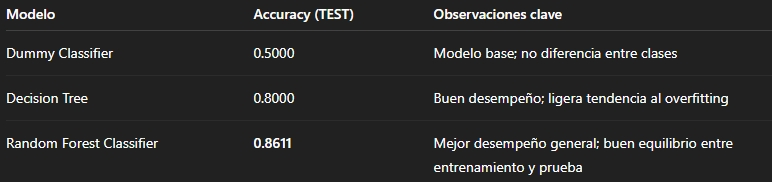

**Conclusión**: El modelo de Random Forest fue el más eficaz para predecir el churn, alcanzando una precisión de 86.11% en el conjunto de prueba, y mostrando un equilibrio sólido entre la capacidad de aprendizaje y la generalización.

**Importancia de las Variables según los Modelos**
Los modelos más avanzados **(árbol de decisión y Random Forest)** permiten medir la importancia relativa de cada variable. Este análisis, en conjunto con la correlación estadística observada en la fase exploratoria, confirma la relevancia de ciertas características:

* **tenure (tiempo de contrato)**: Es la variable con mayor peso. Los clientes con menor antigüedad son significativamente más propensos a cancelar.

* **Contract_Month-to-month**: Este tipo de contrato está altamente asociado al churn. Los contratos mensuales facilitan la salida del cliente.

* **Contract_Two year**: Su relación negativa con el churn sugiere que los contratos a largo plazo generan retención efectiva.

* **InternetService_Fiber optic**: Este tipo de servicio se asocia con una mayor cancelación, posiblemente por problemas técnicos o costo elevado.

* **PaymentMethod_Electronic check**: Este método de pago es un fuerte predictor de churn, tal vez por dificultades en el proceso o menor compromiso financiero.

* **OnlineSecurity, TechSupport, Dependents, Partner**: Variables asociadas con mayor estabilidad, que cuando están presentes, tienden a reducir el riesgo de cancelación.

Estas variables no solo fueron identificadas como estadísticamente significativas en el análisis exploratorio, sino que también fueron seleccionadas por los modelos predictivos como factores críticos en las decisiones de clasificación.

## **Factores Principales que Influyen en la Cancelación**
Con base en el análisis combinado (EDA + modelos), los factores más relevantes que impulsan la evasión de clientes son:

1.  **Falta de antigüedad (Tenure bajo)**: Clientes con contratos recientes tienen una tasa de cancelación significativamente más alta.

2.  **Tipo de contrato**: Los contratos de tipo mensual están altamente correlacionados con el churn. En contraste, los contratos de dos años actúan como anclas.

3.  **Método de pago**: El uso del cheque electrónico está fuertemente ligado al abandono del servicio.

4.  **Tipo de servicio de internet**: El uso de fibra óptica, aunque tecnológicamente superior, muestra una mayor tasa de churn, lo cual puede deberse a expectativas no cumplidas.

5.  **Bajo gasto total acumulado**: Clientes que han invertido poco en el servicio también son más propensos a irse, posiblemente por baja percepción de valor.

6.  **Falta de servicios complementarios (seguridad online, soporte técnico)**: Su ausencia se vincula con una mayor evasión.

## **Estrategias de Retención Propuestas (Reforzadas por Modelos Predictivos)**
A partir de estos resultados, se recomienda a Telecom X implementar las siguientes acciones enfocadas en retener a los clientes con mayor riesgo de cancelación:

1. **Atención Personalizada en los Primeros Meses**
* Implementar un sistema de alertas internas para dar seguimiento proactivo a clientes con menos de 6 meses de antigüedad.

* Ofrecer beneficios exclusivos (bonos de datos, atención prioritaria) durante los primeros meses para fomentar una experiencia positiva temprana.

2. Incentivar Contratos a Largo Plazo
* Crear campañas que promuevan la migración de contratos mensuales a anuales o bianuales mediante descuentos escalonados o regalos por permanencia.

* Utilizar modelos predictivos para identificar clientes con alta probabilidad de conversión a largo plazo.

3. Optimizar la Experiencia con Servicios de Fibra Óptica
* Realizar encuestas de satisfacción específicas para clientes con fibra óptica y tomar acciones correctivas rápidas ante cualquier problema reportado.

* Ofrecer mejoras técnicas o atención premium a clientes que usan este servicio, reduciendo así su frustración potencial.

4. Reducir el Churn Asociado a Cheque Electrónico
* Promover métodos de pago más estables y automatizados (tarjeta de crédito, débito automático) con incentivos pequeños pero tangibles.

* Rediseñar el proceso de pago con cheque electrónico para mejorar su confiabilidad y comunicación.

5. Fomentar Servicios Complementarios
* Identificar clientes que no tienen servicios como seguridad en línea o soporte técnico y ofrecer promociones cruzadas para agregar estos servicios.

* Educar a los clientes sobre los beneficios y el valor agregado que estos servicios representan.

## **onclusión**
La cancelación de clientes puede predecirse de forma confiable utilizando modelos como **Random Forest**. Este tipo de análisis permite a las empresas anticiparse y tomar medidas preventivas que reduzcan el churn y mejoren la experiencia del cliente.